# A SNEAK PEAK INTO THE FOOD IN TORONTO

## 1. Introduction

Toronto City is the most populous city in Canada, an international centre of business, finance, arts, and culture, and is recognized as one of the most multicultural and cosmopolitan cities in the world. It just might be the one of the most diverse city on the planet, as it is home to over 2.7 million people including a large number of immigrants.

As quoted in an article - What Food Tells Us About Culture
"Traditional cuisine is passed down from one generation to the next. It also operates as an expression of cultural identity. Immigrants bring the food of their countries with them wherever they go and cooking traditional food is a way of preserving their culture when they move to new places."

Undoubtedly, Food Diversity is an important part of an ethnically diverse metropolis. The idea of this project is to categorically segment the neighborhoods of Toronto City into major clusters and examine their cuisines. A desirable intention is to examine the neighborhood cluster's food habits and taste. Further examination might reveal if food has any relationship with the diversity of a neighborhood.

This project will help to understand the diversity of a neighborhood by leveraging venue data from Foursquare’s ‘Places API’ and ‘k-means clustering’ machine learning algorithm. Exploratory Data Analysis (EDA) will help to discover further about the culture and diversity of the neighborhood.
Stakeholders would be the one who are interested to use this quantifiable analysis to understand the distribution of different cultures and cuisines over "one of the most diverse city on the planet - Toronto ". Also, this project can be utilized by a new food vendor who is willing to open his or her restaurant. Or by a government authority to examine and study their city's culture diversity better.


## 2. Data Description

Foursquare API is used to explore the data of Toronto, in terms of their food. 

__Toronto data set__
 - Link : https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
 - Description: Toronto Neighborhood Names point file is created as a guide to  Toronto’s neighborhoods that appear on the web resource, “.” Best estimates of label centroids were established at a 1:1,000 scale, but are ideally viewed at a 1:50,000 scale. This dataset will provide the addresses of neighborhood of Toronto.
 
__Foursquare API:__

 - Link: https://developer.foursquare.com/docs
 - Description: Foursquare API, a location data provider, will be used to make RESTful API calls to retrieve data about venues in different neighborhoods. This is the link to Foursquare Venue Category Hierarchy. Venues retrieved from all the neighborhoods are categorized broadly into "Arts & Entertainment", "College & University", "Event", "Food", "Nightlife Spot", "Outdoors & Recreation", etc


The data set of Toronto is imported and processed. After transforming the data to Json files, it is easy to use Pandas to transform them into DataFrame. The required data columns are selected to appear to get the required information. Geopy library is used to get the latitude and longitude values. With the location, the map is created and a direct understanding of the neighborhoods and the food is achieved. The Folium library is also used to show maps after the segmentation.

The machine learning technique, “Clustering” is used to segment the neighborhoods with similar objects on the basis of each neighborhood data. These objects will be given priority on the basis of foot traffic (activity) in their respective neighborhoods. This will help to locate the tourist’s areas and hubs, and one can judge the similarity or dissimilarity between two cities on that basis.


## 3. Methodology

### Libraries and functions are imported

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pprint import pprint # data pretty printer

import requests # library to handle requests
from bs4 import BeautifulSoup  # library to handle web scraping

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from collections import Counter # count occurrences 

from sklearn.cluster import KMeans # import k-means from clustering stage

#install Beautiful Soup and requests for Web Scaping
!pip install BeautifulSoup4
!pip install requests

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.0               |             py_0          26 KB  conda-forge
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    ------------------------------------------------------------
                       

### Data is imported and processed

In [2]:
#get html from wiki page and create soup object
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(source.text, 'lxml')

#using soup object, iterate the .wikitable to get the data from the HTML page and store it into a list
data = []
columns = []
table = soup.find(class_='wikitable')
for index, tr in enumerate(table.find_all('tr')):
    section = []
    for td in tr.find_all(['th','td']):
        section.append(td.text.rstrip())
    
    #First row of data is the header
    if (index == 0):
        columns = section
    else:
        data.append(section)

#convert list into Pandas DataFrame
canada_df = pd.DataFrame(data = data,columns = columns)
canada_df.head()

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


In [3]:
#Remove Boroughs that are 'Not assigned'
canada_df = canada_df[canada_df['Borough'] != 'Not assigned']
canada_df.head()



,Postal code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


In [4]:
# More than one neighborhood can exist in one postal code area, combined these into one row with the neighborhoods separated with a comma
canada_df["Neighborhood"] = canada_df.groupby("Postal code")["Neighborhood"].transform(lambda neigh: ', '.join(neigh))

#remove duplicates
canada_df = canada_df.drop_duplicates()
    
canada_df.head()

,Postal code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


In [5]:
# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough
canada_df['Neighborhood'].replace("Not assigned", canada_df["Borough"],inplace=True)
canada_df.head()

,Postal code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


In [6]:
#reset the index from 0
canada_df=canada_df.reset_index(drop=True)
canada_df.head()

,Postal code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park / Harbourfront
3,M6A,North York,Lawrence Manor / Lawrence Heights
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


In [7]:
canada_df.shape

(103, 3)

In [8]:
import io
import requests
url="https://cocl.us/Geospatial_data"
s=requests.get(url).content
longlat_df=pd.read_csv(io.StringIO(s.decode('utf-8')))



In [9]:
longlat_df=longlat_df.rename(columns={"Postal Code":"Postal code"})

In [10]:
toronto_df = pd.merge(canada_df, longlat_df, on='Postal code')
toronto_df.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494


In [11]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(toronto_df['Borough'].unique()),
        toronto_df.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


#### Use geopy library to get the latitude and longitude values of Toronto City.

In [12]:
address = 'Toronto,Canada'
location = None

# define an instance of the geocoder -> ca_explorer
while location == None:
    try:
        geolocator = Nominatim(user_agent='ca_explorer')
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
    except:
        pass
print('The geograpical coordinates of Toronto city are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto city are 43.6534817, -79.3839347.


#### Create a map of Toronto with neighborhoods superimposed on top

In [13]:
# create map of Toronto using latitude and longitude values

map_toronto = folium.Map(location=[latitude,longitude],zoom_start=10)

for lat,lng,borough,neighbourhood in zip(toronto_df['Latitude'],toronto_df['Longitude'],toronto_df['Borough'],toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_toronto)
    
map_toronto



__Folium__ is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

#### Define Foursquare Credentials and Version

Utilizing the Foursquare API to explore the neighborhoods and segment them.

In [16]:
CLIENT_ID = 'GD3FSXTRDGCPQ3GCNGCTXBEMSOTCTI3BCFFVE2N51X5ON22G' 
CLIENT_SECRET = 'VD4CHGPJGDAUATKAPQVJZWI35HD3EFLIO2ZOW5OI352P5KXJ' 
VERSION = '20180605' 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GD3FSXTRDGCPQ3GCNGCTXBEMSOTCTI3BCFFVE2N51X5ON22G
CLIENT_SECRET:VD4CHGPJGDAUATKAPQVJZWI35HD3EFLIO2ZOW5OI352P5KXJ


#### Fetch Foursquare Venue Category Hierarchy


In [17]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

In [18]:
for key, value in category_results['response']['categories'][0].items():
    print(key, len(str(value)))

id 24
name 20
pluralName 20
shortName 20
icon 98
categories 15910


In [19]:
category_list = category_results['response']['categories']

In [20]:
len(category_list)

10

In [21]:
for data in category_list:
    print(data['id'], data['name'])



4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


### Food & It's Sub-Categories

Let's create a function to return a dictionary with Ids' & Names of Food & It's Sub-Categories.

In [22]:
# function to flatten a 'parent_id' category, returns all categories if checkParentID = False
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict



In [23]:
# this function takes the parent ID and returns 'name' and 'id' of all the sub-categories
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = '4d4b7105d754a06374d81259')

Now, we have all the categories in Food with their id's.



### Explore the first neighborhood to understand the results of GET Request

Get the neighborhood's name.


In [24]:
toronto_df.loc[0, 'Neighborhood']

'Parkwoods'

#### Parkwood's latitude and longitude values.

In [25]:
neighborhood_latitude = toronto_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


#### Now, let's get the Food that is in Parkwood within a radius of 500 meters.



In [26]:
LIMIT = 20 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
categoryId = '4d4b7105d754a06374d81259' # category ID for "Food"

# create URL

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    LIMIT)
url # display URL


'https://api.foursquare.com/v2/venues/search?&client_id=GD3FSXTRDGCPQ3GCNGCTXBEMSOTCTI3BCFFVE2N51X5ON22G&client_secret=VD4CHGPJGDAUATKAPQVJZWI35HD3EFLIO2ZOW5OI352P5KXJ&v=20180605&ll=43.7532586,-79.3296565&radius=500&categoryId=4d4b7105d754a06374d81259&limit=20'

In [27]:
results = requests.get(url).json()

In [28]:
results['response']['venues']

[{'id': '4e6696b6d16433b9ffff47c3',
  'name': 'KFC',
  'location': {'lat': 43.75438666345904,
   'lng': -79.3330206627504,
   'labeledLatLngs': [{'label': 'display',
     'lat': 43.75438666345904,
     'lng': -79.3330206627504}],
   'distance': 298,
   'cc': 'CA',
   'country': 'Canada',
   'formattedAddress': ['Canada']},
  'categories': [{'id': '4bf58dd8d48988d16e941735',
    'name': 'Fast Food Restaurant',
    'pluralName': 'Fast Food Restaurants',
    'shortName': 'Fast Food',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/fastfood_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1586771343',
  'hasPerk': False}]

The category name of the venue 'KFC' is 'Food'.

As, our aim is to segment the neighborhoods of Toronto with respect to the Food in its vicinity. We need to proceed further to fetch this data from all the 103 neighborhoods' venues.


### Create a function to repeat the following process to all the neighborhoods in Toronto:

1.Loop through neighborhoods
 -  Create the API request URL with radius=500, LIMIT=100
 -  Make the GET request
 -  For each neighborhood, return only relevant information for each nearby venue
 -  Append all nearby venues to a list
 
2.Unfold the list & append it to dataframe being returned

The categoryId parameter in the API request URL can be a comma seperated string. So, lets create a comma seperated string from category_dict.


In [29]:
categoryId_list = []
for key, value in category_dict.items():
    categoryId_list.append(key)
categoryId = ','.join(categoryId_list)

In [30]:
def getNearbyFood(names, latitudes, longitudes, radius=1000, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06374d81259", # "Food" category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

#### Let's use pickle library to serialize the information retrieved from GET requests. This step will counter any redundant requests to the Foursquare API.

In [31]:
import pickle # to serialize and deserialize a Python object structure
try:
    with open('toronto_food_venues.pkl', 'rb') as f:
        toronto_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    toronto_venues = getNearbyFood(names=toronto_df['Neighborhood'],
                                        latitudes=toronto_df['Latitude'],
                                        longitudes=toronto_df['Longitude']
                                       )
    with open('toronto_food_venues.pkl', 'wb') as f:
        pickle.dump(toronto_venues, f)
    print("---Dataframe Created and Serialized---")

***Start  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Done*** with 0 venues with incompelete information.
---Dataframe Created and Serialized---


## 4. Analysis & Machine Learning

#### Let's check the size of the resulting dataframe

In [32]:
print(toronto_venues.shape)
toronto_venues.head()

(4281, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.753259,-79.329656,Allwyn's,43.761000,-79.325478,Caribbean Restaurant
2,Parkwoods,43.753259,-79.329656,Tim Hortons,43.760670,-79.326589,Coffee Shop
3,Parkwoods,43.753259,-79.329656,Joey,43.753441,-79.321640,Burger Joint
4,Parkwoods,43.753259,-79.329656,Subway,43.760334,-79.326906,Sandwich Place


#### Unique categories curated from all the returned venues

In [33]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))
toronto_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 158 uniques categories.


Venue Category
Coffee Shop                        614
Pizza Place                        240
Café                               223
Restaurant                         219
Bakery                             183
Fast Food Restaurant               177
Chinese Restaurant                 144
Sandwich Place                     135
Italian Restaurant                 117
Caribbean Restaurant               104
Indian Restaurant                   92
Grocery Store                       77
Middle Eastern Restaurant           74
Burger Joint                        74
Food Court                          73
Sushi Restaurant                    68
Japanese Restaurant                 67
Thai Restaurant                     61
Asian Restaurant                    56
American Restaurant                 55
Mexican Restaurant                  55
Breakfast Spot                      54
Diner                               50
Bubble Tea Shop                     48
Korean Restaurant                   47
Deli / Bod

As we are interested in exploring the diversity of the neighborhood. Let's remove the generalized categories, like Coffee Shop, Cafe, etc.

In [34]:
# list all the categories
unique_categories = toronto_venues['Venue Category'].unique().tolist()
print(', '.join(str(x) for x in unique_categories))

Caribbean Restaurant, Coffee Shop, Burger Joint, Sandwich Place, Fish & Chips Shop, Bakery, Café, Fried Chicken Joint, Chinese Restaurant, Pizza Place, Fast Food Restaurant, Grocery Store, French Restaurant, Food, Event Space, Food Stand, Food Court, Thai Restaurant, American Restaurant, Deli / Bodega, Indian Restaurant, Middle Eastern Restaurant, Portuguese Restaurant, Ice Cream Shop, German Restaurant, Asian Restaurant, Mediterranean Restaurant, Factory, Food Truck, Gourmet Shop, Italian Restaurant, New American Restaurant, Bistro, BBQ Joint, Restaurant, Diner, Butcher, Chocolate Shop, Burrito Place, Beer Bar, Gastropub, Breakfast Spot, Japanese Restaurant, Poutine Place, Brewery, Mexican Restaurant, Vietnamese Restaurant, Sushi Restaurant, Dessert Shop, Salad Place, Vegetarian / Vegan Restaurant, Seafood Restaurant, Korean Restaurant, Tapas Restaurant, Tea Room, Shopping Mall, Food Service, Ramen Restaurant, Bubble Tea Shop, Dumpling Restaurant, Cupcake Shop, African Restaurant, Fil

In [35]:
# manually create a list of generalized categories
general_categories = ['Dessert Shop','Food','Ice Cream Shop','Donut Shop','Bakery','Sandwich Place','Comfort Food Restaurant',
                    'Deli / Bodega','Food Truck','Bagel Shop','Burger Joint','Restaurant','Frozen Yogurt Shop','Coffee Shop',
                    'Diner','Wings Joint','Café','Juice Bar','Breakfast Spot','Grocery Store','Bar','Cupcake Shop',
                    'Pub','Fish & Chips Shop','Cafeteria','Other Nightlife','Arcade','Hot Dog Joint','Food Court',
                    'Health Food Store','Convenience Store','Food & Drink Shop','Cocktail Bar','Cheese Shop',
                    'Snack Place','Sports Bar','Lounge','Theme Restaurant','Buffet','Bubble Tea Shop','Building',
                    'Irish Pub','College Cafeteria','Tea Room','Supermarket','Hotpot Restaurant','Gastropub','Beer Garden',
                    'Fish Market','Beer Bar','Clothing Store','Music Venue','Bistro','Salad Place','Wine Bar','Gourmet Shop',
                    'Indie Movie Theater','Art Gallery','Gift Shop','Pie Shop','Fruit & Vegetable Store',
                    'Street Food Gathering','Dive Bar','Factory','Farmers Market','Mac & Cheese Joint','Creperie',
                    'Candy Store','Event Space','Skating Rink','Miscellaneous Shop','Gas Station','Organic Grocery',
                    'Pastry Shop','Club House','Flea Market','Hotel','Furniture / Home Store','Bookstore','Pet Café',
                    'Gym / Fitness Center','Flower Shop','Financial or Legal Service','Hotel Bar','Hookah Bar','Poke Place',
                    'Market','Gluten-free Restaurant','Smoothie Shop','Butcher','Food Stand','Beach Bar','Beach',
                    'Soup Place','Rock Club','Residential Building (Apartment / Condo)','Laundry Service',
                    'Government Building','Bowling Alley','Nightclub','Park','Moving Target']

In [36]:
# fetch all the required food categories
food_categories =  list(set(unique_categories) - set(general_categories))
print(', '.join(str(x) for x in food_categories))

Szechuan Restaurant, Brazilian Restaurant, Mexican Restaurant, Persian Restaurant, Marijuana Dispensary, Xinjiang Restaurant, Sri Lankan Restaurant, Malay Restaurant, Colombian Restaurant, Argentinian Restaurant, Japanese Curry Restaurant, Indian Restaurant, Office, Japanese Restaurant, Dim Sum Restaurant, Burrito Place, Eastern European Restaurant, Empanada Restaurant, Fried Chicken Joint, Swiss Restaurant, Cajun / Creole Restaurant, Seafood Restaurant, German Restaurant, American Restaurant, Brewery, Gay Bar, Poutine Place, Corporate Cafeteria, Modern European Restaurant, Middle Eastern Restaurant, Falafel Restaurant, Turkish Restaurant, Vietnamese Restaurant, Pide Place, Sushi Restaurant, Kebab Restaurant, Hakka Restaurant, Chinese Breakfast Place, Chinese Restaurant, Scandinavian Restaurant, Italian Restaurant, Pool Hall, New American Restaurant, Pakistani Restaurant, Doner Restaurant, Indonesian Restaurant, Pizza Place, Thai Restaurant, Asian Restaurant, Tibetan Restaurant, Taiwan

Let's remove all the generalized categories, like Coffee Shop, Cafe, etc

In [37]:
toronto_venues = toronto_venues[toronto_venues['Venue Category'].isin(food_categories)].reset_index()
toronto_venues.head(5)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,1,Parkwoods,43.753259,-79.329656,Allwyn's,43.761000,-79.325478,Caribbean Restaurant
2,9,Parkwoods,43.753259,-79.329656,Chick-N-Joy,43.759900,-79.326520,Fried Chicken Joint
3,10,Parkwoods,43.753259,-79.329656,Spicy Chicken House,43.760639,-79.325671,Chinese Restaurant
4,12,Parkwoods,43.753259,-79.329656,Double Double,43.745727,-79.325274,Pizza Place


In [38]:
print('There are {} unique FOOD categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 104 unique FOOD categories.


#### Let's find out how many unique venues can be curated from all the returned venues

In [39]:
print('There are {} uniques venues.'.format(len(toronto_venues['Venue'].unique())))


There are 1427 uniques venues.


### Analyze Each Neighborhood

In [40]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Brazilian Restaurant,Brewery,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chaat Place,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Comic Shop,Corporate Cafeteria,Coworking Space,Cuban Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,Gay Bar,German Restaurant,Greek Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Hungarian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Marijuana Dispensary,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Office,Pakistani Restaurant,Persian Restaurant,Pide Place,Pizza Place,Polish Restaurant,Pool Hall,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Sake Bar,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Shawarma Place,Shopping Mall,South American Restaurant,South Indian Restaurant,Souvlaki Shop,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant,Yemeni Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
toronto_onehot.head()



,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Brazilian Restaurant,Brewery,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chaat Place,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Comic Shop,Corporate Cafeteria,Coworking Space,Cuban Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,Gay Bar,German Restaurant,Greek Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Hungarian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Marijuana Dispensary,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Office,Pakistani Restaurant,Persian Restaurant,Pide Place,Pizza Place,Polish Restaurant,Pool Hall,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Sake Bar,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Shawarma Place,Shopping Mall,South American Restaurant,South Indian Restaurant,Souvlaki Shop,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant,Yemeni Restaurant,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Parkwoods
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Parkwoods
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Parkwoods
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Parkwoods
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Parkwoods


In [42]:
# move neighborhood column to the first column
Neighborhood = toronto_onehot['Neighborhood']

toronto_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
toronto_onehot.insert(0, 'Neighborhood', Neighborhood)

toronto_onehot.head()



,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Brazilian Restaurant,Brewery,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chaat Place,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Comic Shop,Corporate Cafeteria,Coworking Space,Cuban Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,Gay Bar,German Restaurant,Greek Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Hungarian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Marijuana Dispensary,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Office,Pakistani Restaurant,Persian Restaurant,Pide Place,Pizza Place,Polish Restaurant,Pool Hall,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Sake Bar,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Shawarma Place,Shopping Mall,South American Restaurant,South Indian Restaurant,Souvlaki Shop,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant,Yemeni Restaurant
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [43]:
toronto_onehot.shape

(1998, 105)



Let's count venues of each category in each neighborhood


In [44]:
venue_counts = toronto_onehot.groupby('Neighborhood').sum()
venue_counts.head(5)

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Brazilian Restaurant,Brewery,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chaat Place,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Comic Shop,Corporate Cafeteria,Coworking Space,Cuban Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,Gay Bar,German Restaurant,Greek Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Hungarian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Marijuana Dispensary,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Office,Pakistani Restaurant,Persian Restaurant,Pide Place,Pizza Place,Polish Restaurant,Pool Hall,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Sake Bar,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Shawarma Place,Shopping Mall,South American Restaurant,South Indian Restaurant,Souvlaki Shop,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant,Yemeni Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Agincourt,0,0,1,0,0,1,0,3,0,0,0,0,0,0,4,0,0,16,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Alderwood / Long Branch,0,0,1,0,0,2,0,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,1,0,0,0
Bathurst Manor / Wilson Heights / Downsview North,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bayview Village,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bedford Park / Lawrence Manor East,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0


Let's find out the top 10 food categories in Toronto


In [45]:
venue_counts_described = venue_counts.describe().transpose()

In [46]:
venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:10]
venue_top10

,count,mean,std,min,25%,50%,75%,max
Chinese Restaurant,97.0,1.484536,2.704600,0.0,0.0,1.0,1.0,16.0
Vietnamese Restaurant,97.0,0.453608,1.594395,0.0,0.0,0.0,0.0,14.0
Korean Restaurant,97.0,0.484536,1.768435,0.0,0.0,0.0,0.0,13.0
Pizza Place,97.0,2.474227,2.358905,0.0,1.0,2.0,4.0,12.0
Middle Eastern Restaurant,97.0,0.762887,1.390243,0.0,0.0,0.0,1.0,11.0
Caribbean Restaurant,97.0,1.072165,1.780961,0.0,0.0,0.0,2.0,10.0
Fast Food Restaurant,97.0,1.824742,1.534399,0.0,1.0,2.0,3.0,7.0
Indian Restaurant,97.0,0.948454,1.372127,0.0,0.0,0.0,1.0,6.0
Latin American Restaurant,97.0,0.175258,0.736126,0.0,0.0,0.0,0.0,6.0
Greek Restaurant,97.0,0.360825,0.806039,0.0,0.0,0.0,1.0,6.0


In [47]:
venue_top10_list = venue_top10.index.values.tolist()

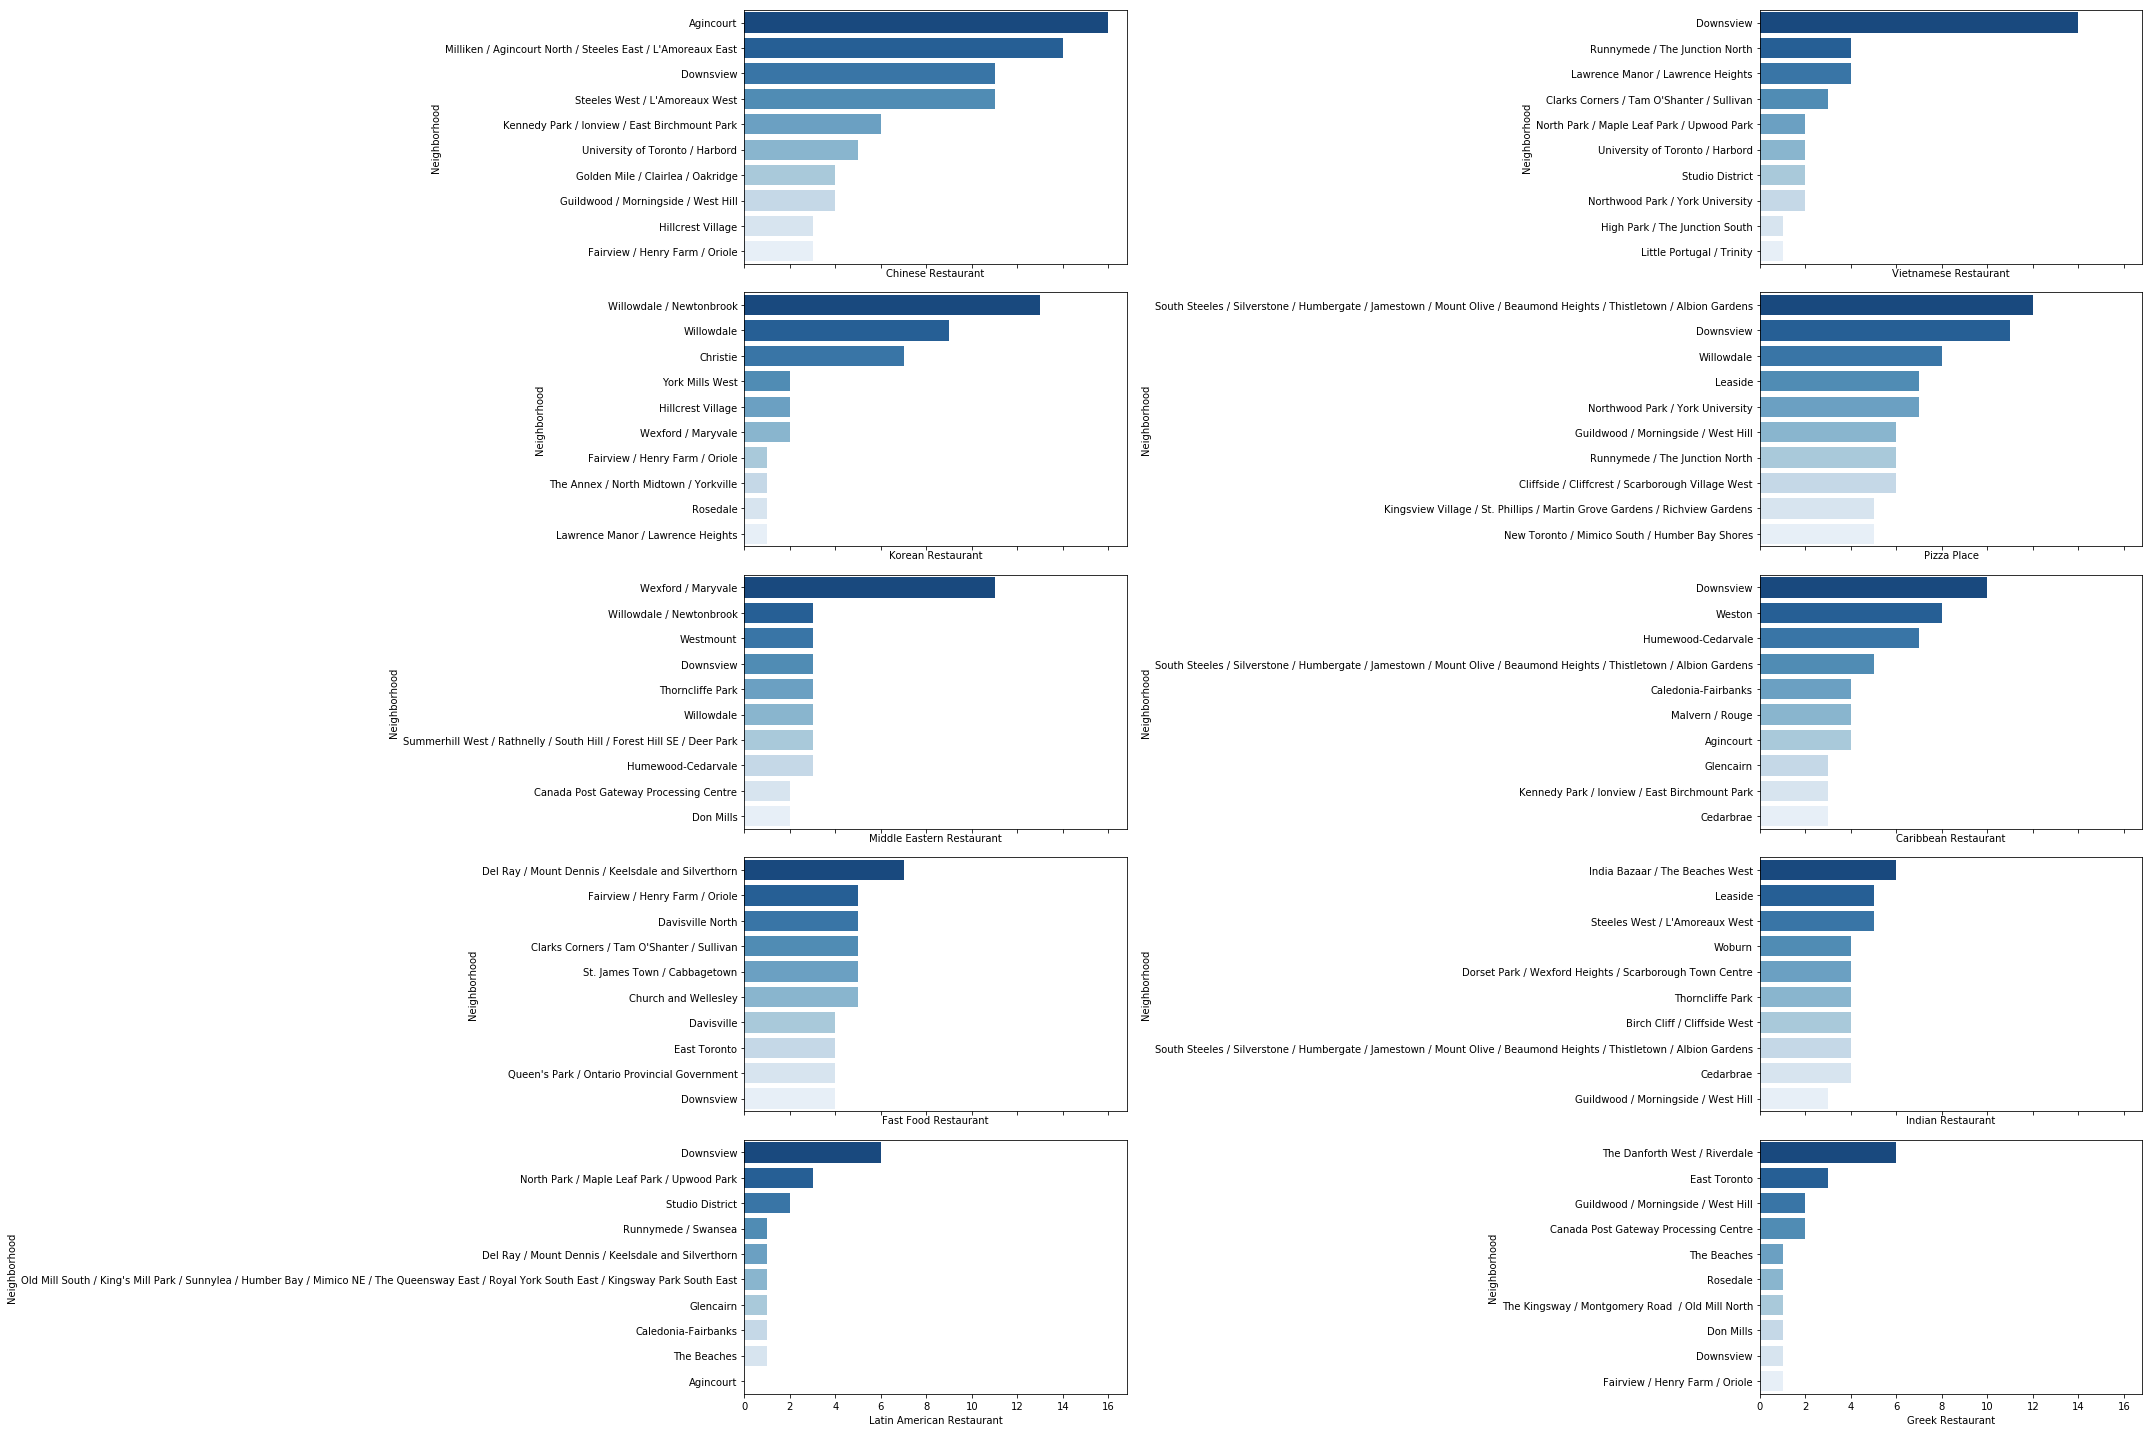

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(5, 2, figsize=(30,20), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_list):
    data = venue_counts[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))
    
plt.tight_layout()
plt.show();

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [49]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Brazilian Restaurant,Brewery,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chaat Place,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Comic Shop,Corporate Cafeteria,Coworking Space,Cuban Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,Gay Bar,German Restaurant,Greek Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Hungarian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Marijuana Dispensary,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Office,Pakistani Restaurant,Persian Restaurant,Pide Place,Pizza Place,Polish Restaurant,Pool Hall,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Sake Bar,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Shawarma Place,Shopping Mall,South American Restaurant,South Indian Restaurant,Souvlaki Shop,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant,Yemeni Restaurant
0,Agincourt,0.0,0.0,0.026316,0.0,0.0,0.026316,0.0,0.078947,0.0,0.0,0.000000,0.0,0.0,0.0,0.105263,0.0,0.0,0.421053,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.052632,0.0,0.000000,0.0,0.026316,0.0,0.0,0.0,0.000000,0.0,0.052632,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.078947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,0.026316,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,0.0,0.026316,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1,Alderwood / Long Branch,0.0,0.0,0.047619,0.0,0.0,0.095238,0.0,0.095238,0.0,0.0,0.047619,0.0,0.0,0.0,0.000000,0.0,0.0,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.0,0.047619,0.0,0.142857,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.047619,0.047619,0.0,0.0,0.0,0.0,0.0,0.095238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.095238,0.0,0.047619,0.0,0.0,0.047619,0.0,0.0,0.0
2,Bathurst Manor / Wilson Heights / Downsview North,0.0,0.0,0.083333,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.00,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.083333,0.0,0.0,0.0,0.083333,0.0,0.000000,0.0,0.083333,0.0,0.166667,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.000000,0.0,0.0,0.222222,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.222222,0.0,0.0,0.0,0.111111,

In [50]:
toronto_grouped.shape

(97, 105)

#### Let's write a function to sort the venues in descending order

In [51]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each neighborhood.

In [52]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))    

In [53]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

In [54]:
for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()



,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt,Chinese Restaurant,Caribbean Restaurant,Pizza Place,BBQ Joint,Indian Restaurant
1,Alderwood / Long Branch,Italian Restaurant,Pizza Place,Asian Restaurant,BBQ Joint,Thai Restaurant
2,Bathurst Manor / Wilson Heights / Downsview North,Pizza Place,Middle Eastern Restaurant,Japanese Restaurant,Mediterranean Restaurant,Fast Food Restaurant
3,Bayview Village,Japanese Restaurant,Asian Restaurant,Sushi Restaurant,Korean Restaurant,Middle Eastern Restaurant
4,Bedford Park / Lawrence Manor East,Pizza Place,Fast Food Restaurant,Sushi Restaurant,Thai Restaurant,Italian Restaurant


### Cluster Neighborhoods

Run k-means to count Neighborhoods for each cluster label for variable cluster size

In [55]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

#### Determine the optimal number of clusters for k-means clustering

__The Elbow Method__ - calculate the sum of squared distances of samples to their closest cluster center for different values of k. The value of k after which there is no siginificant decrease in sum of squared distances is choosen.


In [56]:
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(toronto_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

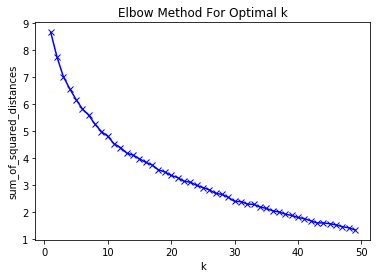

In [57]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');



Elbow method does not seem to help us to determine the optimal number of clusters. Let's use another method.

__The Silhouette Method__ - The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). 

In [58]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,50)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(toronto_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(toronto_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

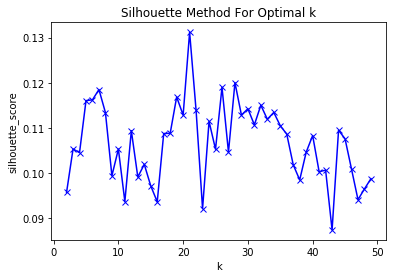

In [59]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

There is a peak at k = 8, k = 20 and k = 34. 20 and 34 clusters will give a very narrow classification of the venues.

Let's set number of clusters = 8

In [60]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(toronto_grouped_clustering)

print(Counter(kmeans.labels_))

Counter({0: 30, 7: 24, 3: 15, 2: 8, 6: 8, 5: 6, 1: 5, 4: 1})


Let's create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.

In [61]:
# add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [62]:
neighborhoods_venues_sorted.head(5)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1,Agincourt,Chinese Restaurant,Caribbean Restaurant,Pizza Place,BBQ Joint,Indian Restaurant
1,0,Alderwood / Long Branch,Italian Restaurant,Pizza Place,Asian Restaurant,BBQ Joint,Thai Restaurant
2,2,Bathurst Manor / Wilson Heights / Downsview North,Pizza Place,Middle Eastern Restaurant,Japanese Restaurant,Mediterranean Restaurant,Fast Food Restaurant
3,2,Bayview Village,Japanese Restaurant,Asian Restaurant,Sushi Restaurant,Korean Restaurant,Middle Eastern Restaurant
4,0,Bedford Park / Lawrence Manor East,Pizza Place,Fast Food Restaurant,Sushi Restaurant,Thai Restaurant,Italian Restaurant


In [63]:
# merge neighborhoods_venues_sorted with nyc_data to add latitude/longitude for each neighborhood
toronto_merged = neighborhoods_venues_sorted.join(toronto_df.set_index('Neighborhood'), on='Neighborhood')
toronto_merged=toronto_merged.drop('Postal code',axis=1)
toronto_merged.head()



,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
0,1,Agincourt,Chinese Restaurant,Caribbean Restaurant,Pizza Place,BBQ Joint,Indian Restaurant,Scarborough,43.794200,-79.262029
1,0,Alderwood / Long Branch,Italian Restaurant,Pizza Place,Asian Restaurant,BBQ Joint,Thai Restaurant,Etobicoke,43.602414,-79.543484
2,2,Bathurst Manor / Wilson Heights / Downsview North,Pizza Place,Middle Eastern Restaurant,Japanese Restaurant,Mediterranean Restaurant,Fast Food Restaurant,North York,43.754328,-79.442259
3,2,Bayview Village,Japanese Restaurant,Asian Restaurant,Sushi Restaurant,Korean Restaurant,Middle Eastern Restaurant,North York,43.786947,-79.385975
4,0,Bedford Park / Lawrence Manor East,Pizza Place,Fast Food Restaurant,Sushi Restaurant,Thai Restaurant,Italian Restaurant,North York,43.733283,-79.419750


Finally, let's visualize the resulting clusters

In [64]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters



## 5. Results

In [65]:
required_column_indices = [2,3,7]
required_column = [list(toronto_merged.columns.values)[i] for i in required_column_indices]
required_column_indices = [2,3,7]

#### Cluster 0

In [66]:
cluster_0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[1:12]]
cluster_0.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
1,Alderwood / Long Branch,Italian Restaurant,Pizza Place,Asian Restaurant,BBQ Joint,Thai Restaurant,Etobicoke,43.602414,-79.543484
4,Bedford Park / Lawrence Manor East,Pizza Place,Fast Food Restaurant,Sushi Restaurant,Thai Restaurant,Italian Restaurant,North York,43.733283,-79.419750
6,Birch Cliff / Cliffside West,Indian Restaurant,Thai Restaurant,Pizza Place,Asian Restaurant,Japanese Restaurant,Scarborough,43.692657,-79.264848
8,Business reply mail Processing CentrE,Fast Food Restaurant,Pizza Place,Italian Restaurant,Indian Restaurant,BBQ Joint,East Toronto,43.662744,-79.321558
9,CN Tower / King and Spadina / Railway Lands / ...,BBQ Joint,Japanese Restaurant,Tapas Restaurant,Pizza Place,New American Restaurant,Downtown Toronto,43.628947,-79.394420


In [67]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

Italian Restaurant      11
Pizza Place              5
Indian Restaurant        5
Japanese Restaurant      3
Fast Food Restaurant     2
Asian Restaurant         2
Greek Restaurant         1
BBQ Joint                1
Burrito Place            1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place                  12
Fast Food Restaurant          4
Italian Restaurant            3
Sushi Restaurant              2
Filipino Restaurant           1
Poutine Place                 1
Indian Restaurant             1
Mexican Restaurant            1
BBQ Joint                     1
Japanese Restaurant           1
Middle Eastern Restaurant     1
Caribbean Restaurant          1
Asian Restaurant              1
Thai Restaurant               1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
North York          6
Etobicoke           5
Central Toronto     5
Scarborough         4
West Toronto        3
Downtown Toronto    3
E

#### Cluster 1

In [68]:
cluster_1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[1:12]]
cluster_1.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
0,Agincourt,Chinese Restaurant,Caribbean Restaurant,Pizza Place,BBQ Joint,Indian Restaurant,Scarborough,43.794200,-79.262029
33,Golden Mile / Clairlea / Oakridge,Chinese Restaurant,Indian Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Thai Restaurant,Scarborough,43.711112,-79.284577
51,Milliken / Agincourt North / Steeles East / L'...,Chinese Restaurant,BBQ Joint,Noodle House,Asian Restaurant,Japanese Restaurant,Scarborough,43.815252,-79.284577
75,Steeles West / L'Amoreaux West,Chinese Restaurant,Indian Restaurant,Fast Food Restaurant,Pizza Place,Caribbean Restaurant,Scarborough,43.799525,-79.318389
85,University of Toronto / Harbord,Chinese Restaurant,Japanese Restaurant,Dumpling Restaurant,Ramen Restaurant,Vietnamese Restaurant,Downtown Toronto,43.662696,-79.400049


In [69]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Chinese Restaurant    5
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Indian Restaurant       2
BBQ Joint               1
Caribbean Restaurant    1
Japanese Restaurant     1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Scarborough         4
Downtown Toronto    1
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 2

In [70]:
cluster_2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[1:12]]
cluster_2.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
2,Bathurst Manor / Wilson Heights / Downsview North,Pizza Place,Middle Eastern Restaurant,Japanese Restaurant,Mediterranean Restaurant,Fast Food Restaurant,North York,43.754328,-79.442259
3,Bayview Village,Japanese Restaurant,Asian Restaurant,Sushi Restaurant,Korean Restaurant,Middle Eastern Restaurant,North York,43.786947,-79.385975
14,Christie,Korean Restaurant,Italian Restaurant,Fried Chicken Joint,Taco Place,Jewish Restaurant,Downtown Toronto,43.669542,-79.422564
79,The Annex / North Midtown / Yorkville,Steakhouse,Italian Restaurant,Sushi Restaurant,Korean Restaurant,Indian Restaurant,Central Toronto,43.672710,-79.405678
90,Wexford / Maryvale,Middle Eastern Restaurant,Pizza Place,Seafood Restaurant,Korean Restaurant,Kebab Restaurant,Scarborough,43.750072,-79.295849


In [71]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Korean Restaurant            4
Steakhouse                   1
Burrito Place                1
Pizza Place                  1
Japanese Restaurant          1
Middle Eastern Restaurant    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place                  3
Italian Restaurant           2
Middle Eastern Restaurant    2
Asian Restaurant             1
Korean Restaurant            1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
North York          6
Downtown Toronto    1
Central Toronto     1
Scarborough         1
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 3

In [72]:
cluster_3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[1:12]]
cluster_3.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
7,Brockton / Parkdale Village / Exhibition Place,Tibetan Restaurant,Fast Food Restaurant,New American Restaurant,Italian Restaurant,American Restaurant,West Toronto,43.636847,-79.428191
13,Central Bay Street,Fast Food Restaurant,Mexican Restaurant,Dumpling Restaurant,Japanese Restaurant,Speakeasy,Downtown Toronto,43.657952,-79.387383
15,Church and Wellesley,Fast Food Restaurant,Japanese Restaurant,Mexican Restaurant,Caribbean Restaurant,Sushi Restaurant,Downtown Toronto,43.665860,-79.383160
16,Clarks Corners / Tam O'Shanter / Sullivan,Fast Food Restaurant,Vietnamese Restaurant,Chinese Restaurant,Asian Restaurant,Fried Chicken Joint,Scarborough,43.781638,-79.304302
19,Davisville,Italian Restaurant,Fast Food Restaurant,Indian Restaurant,Ramen Restaurant,Japanese Restaurant,Central Toronto,43.704324,-79.388790


In [73]:
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

Fast Food Restaurant     8
Italian Restaurant       2
Japanese Restaurant      2
Vietnamese Restaurant    1
Tibetan Restaurant       1
Sushi Restaurant         1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Fast Food Restaurant             6
Japanese Restaurant              2
Mexican Restaurant               2
Greek Restaurant                 1
Pizza Place                      1
Vietnamese Restaurant            1
Vegetarian / Vegan Restaurant    1
Chinese Restaurant               1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Downtown Toronto    6
Central Toronto     3
North York          2
East York           1
Scarborough         1
York                1
West Toronto        1
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 4

In [74]:
cluster_4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[1:12]]
cluster_4.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
95,York Mills / Silver Hills,Middle Eastern Restaurant,Mediterranean Restaurant,Yemeni Restaurant,Gay Bar,Egyptian Restaurant,North York,43.75749,-79.374714


In [75]:
for col in required_column:
    print(cluster_4[col].value_counts(ascending = False))
    print("---------------------------------------------")

Middle Eastern Restaurant    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Mediterranean Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
North York    1
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 5

In [76]:
cluster_5 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[1:12]]
cluster_5.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
10,Caledonia-Fairbanks,Caribbean Restaurant,Mexican Restaurant,Turkish Restaurant,Middle Eastern Restaurant,Fast Food Restaurant,York,43.689026,-79.453512
39,Humberlea / Emery,Caribbean Restaurant,African Restaurant,Italian Restaurant,Yemeni Restaurant,Egyptian Restaurant,North York,43.724766,-79.532242
40,Humewood-Cedarvale,Caribbean Restaurant,Italian Restaurant,Middle Eastern Restaurant,Chinese Restaurant,French Restaurant,York,43.693781,-79.428191
50,Malvern / Rouge,Caribbean Restaurant,Fast Food Restaurant,Fried Chicken Joint,African Restaurant,Indian Restaurant,Scarborough,43.806686,-79.194353
57,Northwest,African Restaurant,Caribbean Restaurant,Ethiopian Restaurant,Swiss Restaurant,Mediterranean Restaurant,Etobicoke,43.706748,-79.594054


In [77]:
for col in required_column:
    print(cluster_5[col].value_counts(ascending = False))
    print("---------------------------------------------")

Caribbean Restaurant    5
African Restaurant      1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Caribbean Restaurant    1
Fast Food Restaurant    1
Italian Restaurant      1
African Restaurant      1
Pizza Place             1
Mexican Restaurant      1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
York           3
North York     1
Scarborough    1
Etobicoke      1
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 6

In [78]:
cluster_6 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[1:12]]
cluster_6.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
5,Berczy Park,Japanese Restaurant,American Restaurant,Fast Food Restaurant,Office,Greek Restaurant,Downtown Toronto,43.644771,-79.373306
18,Commerce Court / Victoria Hotel,Japanese Restaurant,Thai Restaurant,Office,Fast Food Restaurant,Speakeasy,Downtown Toronto,43.648198,-79.379817
29,First Canadian Place / Underground city,Japanese Restaurant,Thai Restaurant,Office,Fast Food Restaurant,French Restaurant,Downtown Toronto,43.648429,-79.382280
35,Harbourfront East / Union Station / Toronto Is...,Fast Food Restaurant,Japanese Restaurant,Office,Greek Restaurant,Brewery,Downtown Toronto,43.640816,-79.381752
65,Richmond / Adelaide / King,Japanese Restaurant,Thai Restaurant,Office,Fast Food Restaurant,French Restaurant,Downtown Toronto,43.650571,-79.384568


In [79]:
for col in required_column:
    print(cluster_6[col].value_counts(ascending = False))
    print("---------------------------------------------")

Japanese Restaurant     7
Fast Food Restaurant    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Thai Restaurant        4
American Restaurant    3
Japanese Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Downtown Toronto    8
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 7

In [80]:
cluster_7 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 7, toronto_merged.columns[1:12]]
cluster_7.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
17,Cliffside / Cliffcrest / Scarborough Village West,Pizza Place,Fast Food Restaurant,Cajun / Creole Restaurant,American Restaurant,Thai Restaurant,Scarborough,43.716316,-79.239476
24,Downsview,Vietnamese Restaurant,Pizza Place,Chinese Restaurant,Caribbean Restaurant,Italian Restaurant,North York,43.737473,-79.464763
24,Downsview,Vietnamese Restaurant,Pizza Place,Chinese Restaurant,Caribbean Restaurant,Italian Restaurant,North York,43.739015,-79.506944
24,Downsview,Vietnamese Restaurant,Pizza Place,Chinese Restaurant,Caribbean Restaurant,Italian Restaurant,North York,43.728496,-79.495697
24,Downsview,Vietnamese Restaurant,Pizza Place,Chinese Restaurant,Caribbean Restaurant,Italian Restaurant,North York,43.761631,-79.520999


In [81]:
for col in required_column:
    print(cluster_7[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizza Place                  20
Vietnamese Restaurant         4
Indian Restaurant             1
Latin American Restaurant     1
Chinese Restaurant            1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place                    6
Fast Food Restaurant           6
Thai Restaurant                3
Vietnamese Restaurant          2
Caribbean Restaurant           2
Chinese Restaurant             2
Japanese Restaurant            1
Indian Restaurant              1
Mexican Restaurant             1
BBQ Joint                      1
Eastern European Restaurant    1
Italian Restaurant             1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
North York      8
Etobicoke       6
Scarborough     5
East York       3
West Toronto    2
East Toronto    2
York            1
Name: Borough, dtype: int64
---------------------------------------------


### THANK YOU

References: Notebook created by Alex Aklson and Polong Lin for the course on Coursera called Applied Data Science Capstone